# Installing required packages

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=f5ca9fdfd1e879de782fe9d92e8d6e01862566c7f4a963893a98e68d57f60dcb
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


# Importing requried packages

In [ ]:
import cv2
import numpy as np
import wget
import bz2

from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm

## Download the zip files

In [ ]:
train_zip = wget.download('https://github.com/jeffreywolberg/sudoku_dataset/blob/master/datasets/v2_train.tar.bz2?raw=true')
test_zip = wget.download('https://github.com/jeffreywolberg/sudoku_dataset/blob/master/datasets/v2_test.tar.bz2?raw=true')
csv_data = wget.download('https://raw.githubusercontent.com/jeffreywolberg/sudoku_dataset/master/outlines_sorted.csv')

## Extract and move the zip files to Data folder

In [ ]:
!if [ -d '/content/Data/' ]; then rm -rf /content/Data else ; fi
!mkdir Data 
!tar -xf /content/v2_train.tar.bz2 -C /content/Data/ && rm -rf /content/v2_train.tar.bz2
!tar -xf /content/v2_test.tar.bz2 -C /content/Data/  && rm -rf /content/v2_test.tar.bz2
!mv outlines_sorted.csv /content/Data

# Helper Functions

In [ ]:
def largest4SideContour(image):
    contours, h = cv2.findContours(
        image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Sorting contours in descending order based on the area
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Looking at top 5 contours and checking if any of them are of size 4
    for cnt in contours[:min(5, len(contours))]:
        if len(approx(cnt)) == 4:
            return cnt
    return None


def approx(cnt):
    try:
        peri = cv2.arcLength(cnt, True)
        app = cv2.approxPolyDP(cnt, 0.01 * peri, True)
        return app
    except:
        return None


def get_rectangle_corners(cnt):
    pts = cnt.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point has the smallest sum whereas the
    # bottom-right has the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # compute the difference between the points -- the top-right
    # will have the minumum difference and the bottom-left will
    # have the maximum difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect


def warp_perspective(rect, grid):
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))

    # ...and now for the height of our new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))

    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))

    # construct our destination points which will be used to
    # map the screen to a top-down, "birds eye" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # calculate the perspective transform matrix and warp
    # the perspective to grab the screen
    M = cv2.getPerspectiveTransform(rect, dst)
    warp = cv2.warpPerspective(grid, M, (maxWidth, maxHeight))
    return cv2.resize(warp, (288, 288))


def getTopLine(image):
    for i, row in enumerate(image):
        if np.any(row):
            return i
    return None


def getBottomLine(image):
    for i in range(image.shape[0] - 1, -1, -1):
        if np.any(image[i]):
            return i
    return None


def getLeftLine(image):
    for i in range(image.shape[1]):
        if np.any(image[:, i]):
            return i
    return None


def getRightLine(image):
    for i in range(image.shape[1] - 1, -1, -1):
        if np.any(image[:, i]):
            return i
    return None


def rowShift(image, start, end, length):
    shifted = np.zeros(image.shape)
    if start + length < 0:
        length = -start
    elif end + length >= image.shape[0]:
        length = image.shape[0] - 1 - end

    for row in range(start, end + 1):
        shifted[row + length] = image[row]
    return shifted


def colShift(image, start, end, length):
    shifted = np.zeros(image.shape)
    if start + length < 0:
        length = -start
    elif end + length >= image.shape[1]:
        length = image.shape[1] - 1 - end

    for col in range(start, end + 1):
        shifted[:, col + length] = image[:, col]
    return shifted


def centerX(digit):
    topLine = getTopLine(digit)
    bottomLine = getBottomLine(digit)
    if topLine is None or bottomLine is None:
        return digit
    centerLine = (topLine + bottomLine) >> 1
    imageCenter = digit.shape[0] >> 1
    digit = rowShift(
        digit, start=topLine, end=bottomLine, length=imageCenter - centerLine)
    return digit


def centerY(digit):
    leftLine = getLeftLine(digit)
    rightLine = getRightLine(digit)
    if leftLine is None or rightLine is None:
        return digit
    centerLine = (leftLine + rightLine) >> 1
    imageCenter = digit.shape[1] >> 1
    digit = colShift(
        digit, start=leftLine, end=rightLine, length=imageCenter - centerLine)
    return digit

# More Helper Functions!

In [ ]:
def process_image(path: str):
    # Load image
    try:
        img = cv2.imread(path)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.adaptiveThreshold(img.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                    cv2.THRESH_BINARY, 11, 3)
        img = 255 - img
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

        contours, h = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        max_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(max_contour)
        img = img[y:y + h, x:x + w]
        img = cv2.resize(img, (288, 288), interpolation=cv2.INTER_AREA)
        img2 = img.copy()
        largest = largest4SideContour(img2)
        app = approx(largest)
        if app is None:
            return img
        corners = get_rectangle_corners(app)
        img = warp_perspective(corners, img)
        return img
    except Exception as e:
        print(str(e))
        return None

def ground_truth(path: str):
    with(open(path, 'r')) as fin:
        lines = fin.readlines()
        truth = []

        # First line contains the details of phone
        # Second line contains size of source image
        # Skipping both these lines
        for line in lines[2:]:
            for value in line.split():
                truth.append(int(value))

        return np.array(truth) # > 0


def clean(cell):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    cell = cv2.morphologyEx(cell, cv2.MORPH_CLOSE, kernel)
    return cell


def centerDigit(digit):
    digit = centerX(digit)
    digit = centerY(digit)
    return digit


def get_cells(sudoku, size=288):
    sudoku = sudoku / 255.
    cells = []
    cell_shape = size // 9
    for i in range(9):
        i = cell_shape * i
        for j in range(9):
            j = j * cell_shape
            cell = sudoku[i: i+cell_shape, j: j+cell_shape]
            cell = clean(cell)
            cell = centerDigit(cell)
            cells.append(cell)

    return np.array(cells)


def compare_outputs(pred, truth):
    errors = 0
    for i in range(len(pred)):
        if pred[i] != truth[i]:
            errors += 1
            break

    if errors:
        return 0
    return 1


def get_sudoku(path: str, model):
    sudoku = process_image(path)

    if sudoku is None:
        raise Exception

    cells = get_cells(sudoku, 288)
    cells = np.reshape(cells, (cells.shape[0], 32, 32, 1))

    # for cell in cells:
    #   cell = cell.reshape((32, 32))
    #   plt.imshow(cell)
    #   plt.show()
    #   v_pred = model.predict(cell.reshape((1, 32, 32, 1)))
    #   print('Predicted: ',np.argmax(v_pred, axis=1))
    #   input("Continue")

    v_pred = model.predict(cells)
    v_pred = np.argmax(v_pred, axis=1)
    sudoku_ext = np.reshape(v_pred, (9, 9))
    return sudoku_ext

## Image before pre-processing

In [ ]:
import matplotlib.pyplot as plt 

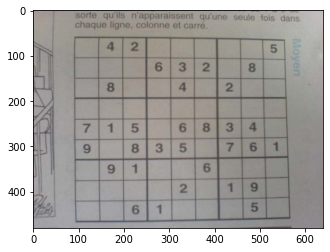

In [ ]:
img = plt.imread('/content/Data/v2_train/image10.jpg')
plt.imshow(img)
plt.show()

## Image after pre-processing

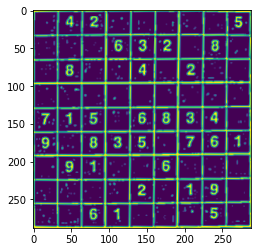

In [ ]:
img = process_image('/content/Data/v2_train/image10.jpg')
plt.imshow(img)
plt.show()

In [ ]:
img.shape

(288, 288)

In [ ]:
cells_img = get_cells(img, size=288)

In [ ]:
cells_img.shape

(81, 32, 32)

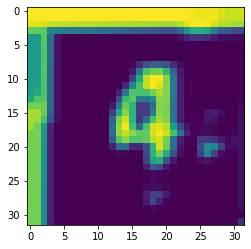

In [ ]:
plt.imshow(cells_img[1])
plt.show()

# Step 1: Preparing the training dataset

In [ ]:
X_train = []
y_train = []
y_train_all = []

for path in tqdm(glob('/content/Data/v2_train/*.jpg')):
  path = path[:-4]
  processed_img = process_image(path + '.jpg')
  if processed_img is None:
    continue
  X_train.append(processed_img)
  y_train.append(ground_truth(path + '.dat') > 0)
  y_train_all.append(ground_truth(path + '.dat'))

X_train = np.array(X_train)
y_train = np.array(y_train)
y_train_all = np.array(y_train_all)

X_test = []
y_test = []
y_test_all = []

for path in tqdm(glob('/content/Data/v2_test/*.jpg')):
  path = path[:-4]
  processed_img = process_image(path + '.jpg')
  if processed_img is None:
    continue
  X_test.append(processed_img)
  y_test.append(ground_truth(path + '.dat') > 0)
  y_test_all.append(ground_truth(path + '.dat'))

X_test = np.array(X_test)
y_test = np.array(y_test)
y_test_all = np.array(y_test_all)

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
X_train.shape, X_test.shape

((160, 288, 288), (40, 288, 288))

In [ ]:
y_train.shape, y_test.shape, y_train_all.shape, y_test_all.shape

((160, 81), (40, 81), (160, 81), (40, 81))

In [ ]:
digit_train_img = []
digit_train_truth = []
digit_train_truth_all = []

for i, sudoku in tqdm(enumerate(X_train)):
		digit_train_img.extend(get_cells(sudoku, size=288))
		digit_train_truth.extend(y_train[i])
		digit_train_truth_all.extend(y_train_all[i])

digit_train_truth = np.array(digit_train_truth)
digit_train_img = np.array(digit_train_img)
digit_train_truth_all = np.array(digit_train_truth_all)

0it [00:00, ?it/s]

In [ ]:
digit_train_img.shape, digit_train_truth.shape

((12960, 32, 32), (12960,))

In [ ]:
digit_test_img = []
digit_test_truth = []
digit_test_truth_all = []

for i, sudoku in tqdm(enumerate(X_test)):
		digit_test_img.extend(get_cells(sudoku, size=288))
		digit_test_truth.extend(y_test[i])
		digit_test_truth_all.extend(y_test_all[i])

digit_test_truth = np.array(digit_test_truth)
digit_test_img = np.array(digit_test_img)
digit_test_truth_all = np.array(digit_test_truth_all)

0it [00:00, ?it/s]

In [ ]:
digit_test_img.shape, digit_test_truth.shape

((3240, 32, 32), (3240,))

In [ ]:
digit_train_img = digit_train_img.reshape(-1, 1024)
digit_test_img = digit_test_img.reshape(-1, 1024)

In [ ]:
digit_train_img.shape

(12960, 1024)

In [ ]:
lr = LogisticRegression()
lr.fit(digit_train_img, digit_train_truth)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
y_pred = lr.predict(digit_test_img)

In [ ]:
y_pred

array([False, False,  True, ..., False,  True, False])

In [ ]:
#y_pred = y_pred > 0.5

In [ ]:
print(classification_report(y_pred=y_pred, y_true=digit_test_truth))

              precision    recall  f1-score   support

       False       0.95      0.96      0.96      2084
        True       0.92      0.92      0.92      1156

    accuracy                           0.94      3240
   macro avg       0.94      0.94      0.94      3240
weighted avg       0.94      0.94      0.94      3240



In [ ]:
from collections import Counter
Counter(digit_train_truth)

Counter({False: 8304, True: 4656})

# Now, let's distinguish between the digits present

In [ ]:
# Extract the examples that have a digit in them

digit_train_img_nz = digit_train_img[digit_train_truth_all > 0]
digit_train_truth_nz = digit_train_truth_all[digit_train_truth_all > 0]

digit_test_img_nz = digit_test_img[digit_test_truth_all > 0]
digit_test_truth_nz = digit_test_truth_all[digit_test_truth_all > 0]

In [ ]:
# Train 9 different Logistic Regression models, one for each class (digit)
models = []

for cl in range(1, 10):
  model = LogisticRegression()
  model.fit(digit_train_img_nz, digit_train_truth_nz == cl)
  models.append(model)

In [ ]:
# For each test example, run all 9 classifiers (digit 1 to 9)

preds = []
for cl in range(1, 10):
  preds.append(models[cl - 1].predict_proba(digit_test_img_nz)[:, 1])

In [ ]:
(digit_test_truth_nz - 1 == np.array(preds).T.argmax(axis=1)).mean()

0.5700692041522492

In [ ]:
# Take the most confident classifier as the predicted label
print(classification_report(digit_test_truth_nz - 1, np.array(preds).T.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.71      0.62      0.66       129
           1       0.67      0.64      0.65       139
           2       0.58      0.54      0.56       123
           3       0.55      0.63      0.59       124
           4       0.55      0.59      0.57       127
           5       0.44      0.41      0.42       117
           6       0.67      0.69      0.68       125
           7       0.54      0.52      0.53       147
           8       0.43      0.47      0.45       125

    accuracy                           0.57      1156
   macro avg       0.57      0.57      0.57      1156
weighted avg       0.57      0.57      0.57      1156



In [ ]:
from collections import Counter
Counter(digit_test_truth_nz)

Counter({1: 129,
         2: 139,
         3: 123,
         4: 124,
         5: 127,
         6: 117,
         7: 125,
         8: 147,
         9: 125})